# Lesson 1 - What's your pet

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai import *
from fastai.vision import *

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
print(URLs)

<class 'fastai.datasets.URLs'>


In [3]:
path = untar_data(URLs.PETS); path

PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

['images', 'annotations']

In [4]:
path_anno = path/'annotations'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)

In [10]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [6]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

NameError: name 'pat' is not defined

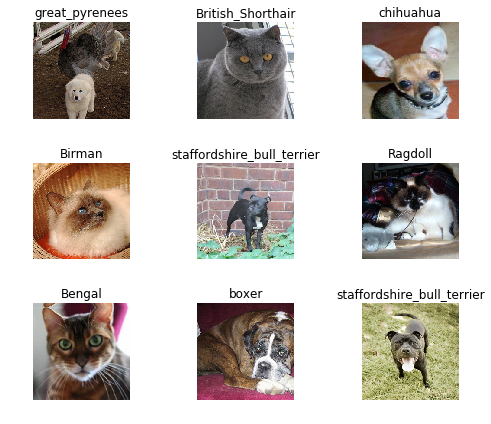

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

['Sphynx', 'Ragdoll', 'Egyptian_Mau', 'wheaten_terrier', 'american_pit_bull_terrier', 'pomeranian', 'boxer', 'saint_bernard', 'Maine_Coon', 'Siamese', 'havanese', 'Russian_Blue', 'yorkshire_terrier', 'great_pyrenees', 'samoyed', 'american_bulldog', 'Bengal', 'scottish_terrier', 'Persian', 'staffordshire_bull_terrier', 'keeshond', 'Abyssinian', 'Bombay', 'japanese_chin', 'chihuahua', 'leonberger', 'newfoundland', 'german_shorthaired', 'miniature_pinscher', 'shiba_inu', 'British_Shorthair', 'basset_hound', 'english_cocker_spaniel', 'Birman', 'english_setter', 'pug', 'beagle']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 ouptuts).

We will train for 5 epochs (5 cycles through all our data).

In [14]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [15]:
learn.fit_one_cycle(4)

Total time: 04:01
epoch  train loss  valid loss  error_rate
1      1.150759    0.315512    0.097804    (01:02)
2      0.497859    0.239817    0.079840    (00:59)
3      0.314072    0.231811    0.077179    (00:59)
4      0.231387    0.217510    0.065868    (00:59)



In [ ]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

In [29]:
interp.losses #logloss for each record in validation set

tensor([0.0459, 0.0135, 2.3114,  ..., 0.0187, 0.7710, 0.0601])

In [40]:
interp.pred_class

tensor([ 1, 11, 14,  ..., 15, 28, 31])

In [35]:
tl = interp.top_losses(9,True)

In [37]:
tl[1] # top 9 idx with highest loss

tensor([ 698, 1335, 1260,  125, 1105, 1345,  969, 1223,    3])

In [92]:
top_loss_idx = tl[1][8] # image idx
pred_idx=interp.pred_class[top_loss_idx]
data.classes[pred_idx]

'Egyptian_Mau'

In [93]:
label_idx = data.valid_ds[top_loss_idx][1]
data.classes[label_idx]

'Bengal'

In [94]:
interp.losses[top_loss_idx]

tensor(4.0450)

In [95]:
interp.probs[top_loss_idx]

tensor([0.9222, 0.2867, 1.0000, 0.0740, 0.3107, 0.1515, 0.3409, 0.0409, 0.9521,
        0.2463, 0.1998, 0.9870, 0.5718, 0.0703, 0.1250, 0.1152, 0.9995, 0.1875,
        0.6053, 0.0473, 0.0799, 0.9655, 0.9338, 0.2624, 0.2640, 0.0299, 0.0756,
        0.6210, 0.5459, 0.0113, 0.9787, 0.1973, 0.1501, 0.2548, 0.6105, 0.6172,
        0.2551])

In [96]:
interp.probs[top_loss_idx][pred_idx] # prob on pred label

tensor(1.0000)

In [98]:
interp.probs[top_loss_idx][label_idx] # prob on true label

tensor(0.9995)

In [99]:
interp.probs[top_loss_idx].sum() # there is no softmax layer at the end of the model, so sum does not have to be 1

tensor(15.0870)

In [100]:
# let see how the model get these predictions
preds=learn.get_preds()

In [101]:
np.exp(2)

7.38905609893065

In [102]:
np.e**2

7.3890560989306495

In [103]:
preds[0][top_loss_idx] # this is raw output from model

tensor([ 2.4730, -0.9114, 11.6620, -2.5262, -0.7970, -1.7232, -0.6594, -3.1536,
         2.9903, -1.1185, -1.3872,  4.3273,  0.2890, -2.5823, -1.9464, -2.0391,
         7.6364, -1.4664,  0.4275, -3.0023, -2.4440,  3.3315,  2.6466, -1.0334,
        -1.0252, -3.4794, -2.5038,  0.4938,  0.1842, -4.4680,  3.8286, -1.4031,
        -1.7341, -1.0734,  0.4495,  0.4776, -1.0715])

In [106]:
# pred class raw output vs true class raw output
preds[0][top_loss_idx][pred_idx],preds[0][top_loss_idx][label_idx]

(tensor(11.6620), tensor(7.6364))

In [104]:
preds[0][top_loss_idx].sigmoid() # convert to probability using sigmoid. 
# Using sigmoid instead of softmax to see how confident the model is for EACH class

tensor([0.9222, 0.2867, 1.0000, 0.0740, 0.3107, 0.1515, 0.3409, 0.0409, 0.9521,
        0.2463, 0.1998, 0.9870, 0.5718, 0.0703, 0.1250, 0.1152, 0.9995, 0.1875,
        0.6053, 0.0473, 0.0799, 0.9655, 0.9338, 0.2624, 0.2640, 0.0299, 0.0756,
        0.6210, 0.5459, 0.0113, 0.9787, 0.1973, 0.1501, 0.2548, 0.6105, 0.6172,
        0.2551])

In [105]:
# identical to this
interp.probs[top_loss_idx]

tensor([0.9222, 0.2867, 1.0000, 0.0740, 0.3107, 0.1515, 0.3409, 0.0409, 0.9521,
        0.2463, 0.1998, 0.9870, 0.5718, 0.0703, 0.1250, 0.1152, 0.9995, 0.1875,
        0.6053, 0.0473, 0.0799, 0.9655, 0.9338, 0.2624, 0.2640, 0.0299, 0.0756,
        0.6210, 0.5459, 0.0113, 0.9787, 0.1973, 0.1501, 0.2548, 0.6105, 0.6172,
        0.2551])

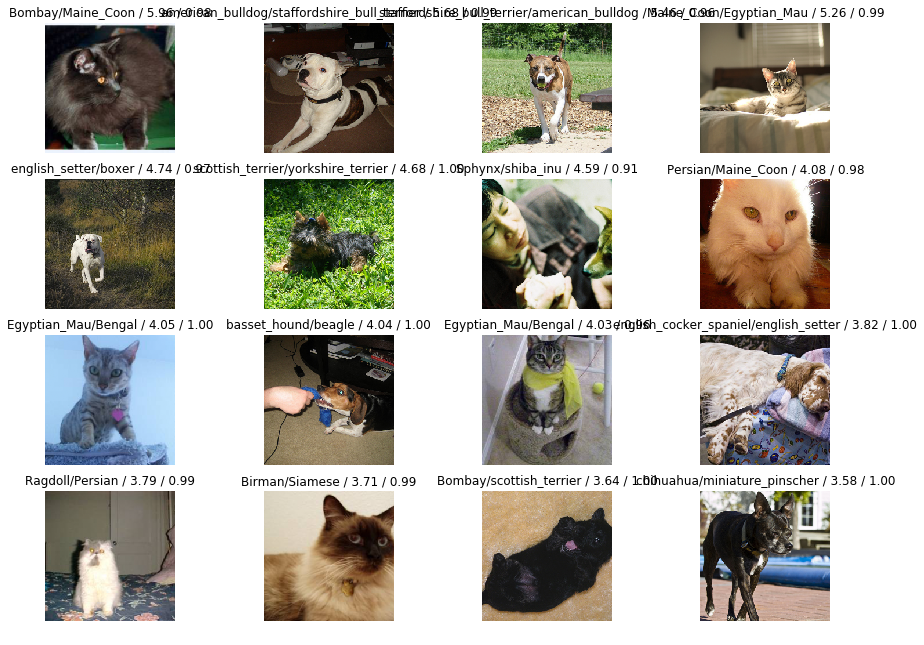

In [31]:
interp.plot_top_losses(16, figsize=(15,11))
# pred label/true label/log loss (should be high)/ probability of true label
# Note that probability of true label could be high (like in this 9th picture where prob of true label is 0.9995 
# but prob of pred label, or wrong label, is 1.0. In the picture .9995 is rounded to 1, hence the confusion)


In [17]:
doc(interp.plot_top_losses)

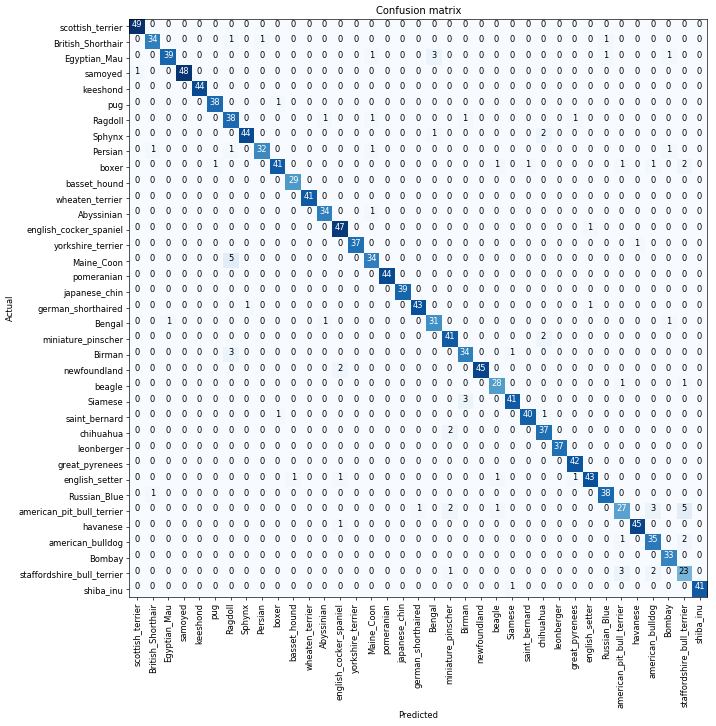

In [18]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('Maine_Coon', 'Ragdoll', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Birman', 'Ragdoll', 3),
 ('Siamese', 'Birman', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [22]:
learn.unfreeze()

In [14]:
learn.fit_one_cycle(1)

Total time: 00:21
epoch  train loss  valid loss  error_rate
0      1.017550    0.566690    0.185629    (00:21)



In [14]:
learn.load('stage-1')

In [23]:
learn.lr_find()

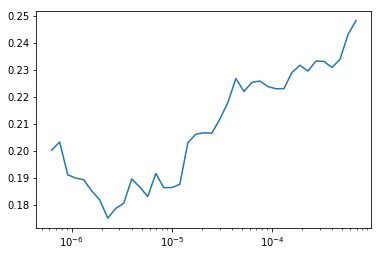

In [24]:
learn.recorder.plot()

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 00:42
epoch  train loss  valid loss  error_rate
1      0.200614    0.176755    0.057219    (00:21)
2      0.197669    0.169028    0.053892    (00:20)



That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here.

In [26]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=299, bs=48)
data.normalize(imagenet_stats)

In [27]:
learn = ConvLearner(data, models.resnet50, metrics=error_rate)

In [18]:
learn.fit_one_cycle(5)

Total time: 04:23
epoch  train loss  valid loss  error_rate
0      0.624318    0.215355    0.072512    (01:00)
1      0.355879    0.235637    0.077126    (00:50)
2      0.253141    0.189441    0.056032    (00:50)
3      0.172204    0.142786    0.052076    (00:50)
4      0.118077    0.132798    0.043507    (00:51)



In [21]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [29]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

Total time: 01:16
epoch  train loss  valid loss  error_rate
1      0.099166    0.137234    0.047462    (01:16)



In this case it doesn't, so let's go back to our previous model.

In [32]:
learn.load('stage-1-50')

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

In [34]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Ragdoll', 'Birman', 6),
 ('Birman', 'Ragdoll', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3)]

## Other data formats

In [12]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/jhoward/.fastai/data/mnist_sample')

In [13]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

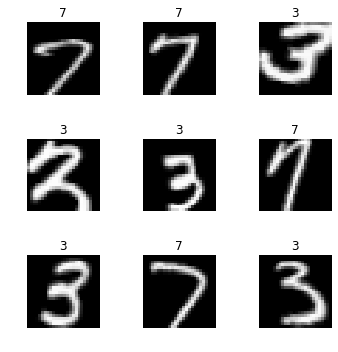

In [14]:
data.show_batch(rows=3, figsize=(5,5))

In [16]:
learn = ConvLearner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:11
epoch  train loss  valid loss  accuracy
1      0.108823    0.025363    0.991168  (00:05)
2      0.061547    0.020443    0.994112  (00:05)



In [17]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [18]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

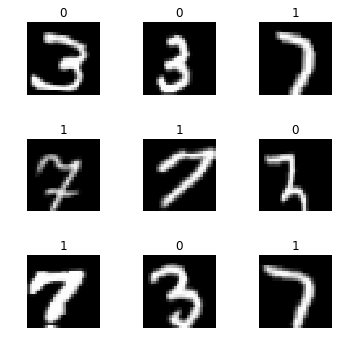

In [20]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [21]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [22]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/jhoward/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/jhoward/.fastai/data/mnist_sample/train/3/21102.png')]

In [23]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [25]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [27]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [28]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']